In [81]:
# Imports
import os
import re
import unicodedata
from datetime import datetime
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ahocorasick import Automaton
from scipy.stats import zscore
from scipy.stats import mannwhitneyu


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

 
#from gensim.models.phrases import Phrases, Phraser


# Settings
pd.set_option('display.max_rows', None)


# Importing Data

First I import and prepare the company- and the scraping dataframe.

In [82]:
# Importing the scraped website data with keywords
data_final = pd.read_excel('Documentation/Final Search Results.xlsx')
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8367 entries, 0 to 8366
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             8367 non-null   int64  
 1   website                8367 non-null   object 
 2   text_len               8367 non-null   int64  
 3   source                 8367 non-null   object 
 4   text                   8367 non-null   object 
 5   type                   8367 non-null   object 
 6   closest_snapshot       6596 non-null   object 
 7   closest_snapshot_time  6596 non-null   float64
 8   snapshot_in_window     8367 non-null   int64  
 9   text_preprocessed      8359 non-null   object 
 10  ai_keyword_count       8367 non-null   int64  
 11  matched_keywords       1188 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 784.5+ KB


In [83]:
# Importing the company data
cb = pd.read_csv('Data/Crunchbase/rand_sample_3.csv') # Random Sample
cb_AI = pd.read_csv('Data/Crunchbase/cb_AI.csv') # Oversample 

# Adding a column to indicate the source of each scraped company
cb['source'] = 0
cb_AI['source'] = 1

# Concatenating two company-dataframes
cb = pd.concat([cb, cb_AI])
cb = cb.drop_duplicates(subset = ['website'])

# Displaying the information of the concatenated DataFrame
cb.info()
cb.head()

<class 'pandas.core.frame.DataFrame'>
Index: 17982 entries, 0 to 3962
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              17982 non-null  int64  
 1   company                                 17982 non-null  object 
 2   Founded Date                            17982 non-null  object 
 3   website                                 17982 non-null  object 
 4   Headquarters Location                   17982 non-null  object 
 5   Industry Groups                         17982 non-null  object 
 6   Industries                              17982 non-null  object 
 7   CB Rank (Company)                       17982 non-null  float64
 8   Full Description                        11998 non-null  object 
 9   Number of Employees                     17982 non-null  object 
 10  Number of Funding Rounds                17982 non-null  float64


,Unnamed: 0,company,Founded Date,website,Headquarters Location,Industry Groups,Industries,CB Rank (Company),Full Description,Number of Employees,...,IPO Date,Valuation at IPO Currency (in USD),IPqwery - Patents Granted,IPqwery - Trademarks Registered,IPqwery - Most Popular Patent Class,NA Count,age,founding_year,org_uuid,source
0,1986,Okay,2019-01-01,https://www.okayhq.com/,"San Francisco, California, United States","Data and Analytics, Internet Services, Software","Business Intelligence, Developer Tools, Intern...",23163.0,Okay offers dashboards and user-friendly workf...,101-250,...,NaN,NaN,NaN,NaN,NaN,0,5,2019,1947,0
1,101566,Code Builderz,2020-01-01,https://codebuilderz.com,"Irvine, California, United States","Design, Sales and Marketing, Software","Digital Marketing, Software, Web Design, Web D...",3022667.0,Code Builderz is a software company that provi...,11-50,...,NaN,NaN,NaN,NaN,NaN,6,4,2020,88835,0
2,17422,PromptLayer,2021-08-01,https://www.promptlayer.com,"New York, New York, United States",Software,Software,130969.0,NaN,1-10,...,NaN,NaN,0.0,0.0,NaN,2,2,2021,16596,0
3,82006,American Safety,2019-01-01,https://american-safetyllc.com,"Belle Chasse, Louisiana, United States","Commerce and Shopping, Education, Manufacturing","Industrial, Rental, Training",2051287.0,NaN,51-100,...,NaN,NaN,NaN,NaN,NaN,6,5,2019,72521,0
4,58824,Nerdee's,2020-01-01,https://www.nerdees.com,"Walnut, California, United States","Clothing and Apparel, Commerce and Shopping, C...","Apparel, E-Commerce, Fashion, Shoes",1038376.0,"Nerdee's a seller of clothing, accessories, ga...",11-50,...,NaN,NaN,NaN,NaN,NaN,6,4,2020,52464,0


Next, I merge the two dataframes into one for further analysis. 

In [84]:
# Merging crunchbase data with scraped website texts
cb.rename(columns = {'Website': 'website', 'Unnamed: 0': 'ID'}, inplace = True)
df = pd.merge(cb, data_final , on = 'website', how = 'left')

# Saving the dataframe
df.to_csv('Data/Crunchbase/scrape_2.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17982 entries, 0 to 17981
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   ID                                      17982 non-null  int64  
 1   company                                 17982 non-null  object 
 2   Founded Date                            17982 non-null  object 
 3   website                                 17982 non-null  object 
 4   Headquarters Location                   17982 non-null  object 
 5   Industry Groups                         17982 non-null  object 
 6   Industries                              17982 non-null  object 
 7   CB Rank (Company)                       17982 non-null  float64
 8   Full Description                        11998 non-null  object 
 9   Number of Employees                     17982 non-null  object 
 10  Number of Funding Rounds                17982 non-null  fl

Now, I perform some sanity checks to make sure that there is no erroneous companies. Further, I limit the dataframe to only include companies that have lesse than 2 funding rounds, as that would pose a strong signal and cut skew my analysis of AI-related keywords as weak signals. 

In [85]:
df.head()

,ID,company,Founded Date,website,Headquarters Location,Industry Groups,Industries,CB Rank (Company),Full Description,Number of Employees,...,text_len,source_y,text,type,closest_snapshot,closest_snapshot_time,snapshot_in_window,text_preprocessed,ai_keyword_count,matched_keywords
0,1986,Okay,2019-01-01,https://www.okayhq.com/,"San Francisco, California, United States","Data and Analytics, Internet Services, Software","Business Intelligence, Developer Tools, Intern...",23163.0,Okay offers dashboards and user-friendly workf...,101-250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101566,Code Builderz,2020-01-01,https://codebuilderz.com,"Irvine, California, United States","Design, Sales and Marketing, Software","Digital Marketing, Software, Web Design, Web D...",3022667.0,Code Builderz is a software company that provi...,11-50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,17422,PromptLayer,2021-08-01,https://www.promptlayer.com,"New York, New York, United States",Software,Software,130969.0,NaN,1-10,...,103.0,crunchbase,PromptLayer - The first platform built for pr...,startup,"{'status': '200', 'available': True, 'url': 'h...",2.023010e+13,1.0,promptlayer first platform built prompt engine...,0.0,NaN
3,82006,American Safety,2019-01-01,https://american-safetyllc.com,"Belle Chasse, Louisiana, United States","Commerce and Shopping, Education, Manufacturing","Industrial, Rental, Training",2051287.0,NaN,51-100,...,7306.0,crunchbase,About Us | American Safety LLC RESPONSE TEAMS ...,startup,"{'status': '200', 'available': True, 'url': 'h...",2.020080e+13,1.0,us american safety llc response teams medical ...,0.0,NaN
4,58824,Nerdee's,2020-01-01,https://www.nerdees.com,"Walnut, California, United States","Clothing and Apparel, Commerce and Shopping, C...","Apparel, E-Commerce, Fashion, Shoes",1038376.0,"Nerdee's a seller of clothing, accessories, ga...",11-50,...,195537.0,crunchbase,Nerdee s Top Sellers Menu Page Nerdee s Deals ...,startup,"{'status': '200', 'available': True, 'url': 'h...",2.020121e+13,1.0,nerdee top sellers menu page nerdee deals nerd...,0.0,NaN


In [86]:
# Converting dates to the datetime format
df['Founded Date'] = pd.to_datetime(df['Founded Date'])
df['Last Funding Date'] = pd.to_datetime(df['Last Funding Date'])

# Removing companies with more than 2 funding rounds
df = df[df['Number of Funding Rounds'] < 2]

# Dropping companies with missing website text
df.dropna(subset = 'text', inplace = True)

# Checking the resulting dataframe
print(f"Number of valid companies {len(df)}")

Number of valid companies 7964


Selecting only the startups relevant for my analysis, I am left with the following dataframe:

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7964 entries, 2 to 17978
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   ID                                      7964 non-null   int64         
 1   company                                 7964 non-null   object        
 2   Founded Date                            7964 non-null   datetime64[ns]
 3   website                                 7964 non-null   object        
 4   Headquarters Location                   7964 non-null   object        
 5   Industry Groups                         7964 non-null   object        
 6   Industries                              7964 non-null   object        
 7   CB Rank (Company)                       7964 non-null   float64       
 8   Full Description                        4794 non-null   object        
 9   Number of Employees                     7964 non-null   

# Feature Engineering

## Derivative Features
Based on existing features, I derive the following new features.

In [88]:
df['Headquarters State'] = df['Headquarters Location'].str.split(', ').str[1]


## Binary Conversions
To draw better conclusions on the general effects of AI on funding success, I also introduce binary features for: 
- Funding (1 = received funding)
- AI (1 = industry group contains "Artificial Intelligence")
- Keywords (1 = AI-related keywords identified in website text)
- Series A (1 = company reached series A)
- Funding Success (1 = company gets second funding) 

These are all added next to the alreadyaa created binary indicator for use of AI ('keyword_bin')

In [89]:
# Adding binary variable for funding (1 = received funding, 0 = no funding)
df['funding_bin'] = np.where(df['Total Funding Amount Currency (in USD)'] > 0, 1, 0)
df['funding_bin'] = df['funding_bin'].astype(bool)

# Adding binary variable for having AI-related keywords in their website text
df['keyword_bin'] = np.where(df['ai_keyword_count'] >0, 1, 0)
df['keyword_bin'] = df['keyword_bin'].astype(bool)

# Adding binary variable for getting a second round of funding
df['fund_success'] = np.where(df['Last Funding Amount Currency (in USD)'] < df['Total Funding Amount Currency (in USD)'], 1, 0)
df['fund_success'] = df['fund_success'].astype(bool)

# Adding binary variable for having 'Artificial Intelligence' as industry group
df['AI_bin'] = df['Industry Groups'].apply(lambda x: 1 if "Artificial Intelligence" in str(x) else 0)
df['AI_bin'] = df['AI_bin'].astype(bool)

# Converting snapshot_in_window to binary type
df['snapshot_in_window'] = df['snapshot_in_window'].astype(bool)

In [90]:
df.head()

,ID,company,Founded Date,website,Headquarters Location,Industry Groups,Industries,CB Rank (Company),Full Description,Number of Employees,...,closest_snapshot_time,snapshot_in_window,text_preprocessed,ai_keyword_count,matched_keywords,Headquarters State,funding_bin,keyword_bin,fund_success,AI_bin
2,17422,PromptLayer,2021-08-01,https://www.promptlayer.com,"New York, New York, United States",Software,Software,130969.0,NaN,1-10,...,2.023010e+13,True,promptlayer first platform built prompt engine...,0.0,NaN,New York,False,False,False,False
3,82006,American Safety,2019-01-01,https://american-safetyllc.com,"Belle Chasse, Louisiana, United States","Commerce and Shopping, Education, Manufacturing","Industrial, Rental, Training",2051287.0,NaN,51-100,...,2.020080e+13,True,us american safety llc response teams medical ...,0.0,NaN,Louisiana,False,False,False,False
4,58824,Nerdee's,2020-01-01,https://www.nerdees.com,"Walnut, California, United States","Clothing and Apparel, Commerce and Shopping, C...","Apparel, E-Commerce, Fashion, Shoes",1038376.0,"Nerdee's a seller of clothing, accessories, ga...",11-50,...,2.020121e+13,True,nerdee top sellers menu page nerdee deals nerd...,0.0,NaN,California,False,False,False,False
6,58333,Ziegel,2018-07-06,https://www.ziegel.es,"Playa Del Rey, California, United States",Real Estate,Real Estate,987441.0,"We offer support, infrastructures and conditio...",51-100,...,2.020081e+13,True,ziegelianos vendemos juntos aqui conoceras nue...,0.0,NaN,California,False,False,False,False
10,25169,Lodestar,2019-08-01,https://www.lodestar.ai,"San Jose, California, United States","Artificial Intelligence (AI), Data and Analyti...","Artificial Intelligence (AI), Computer Vision,...",216067.0,With Lodestar you can annotate video far faste...,11-50,...,NaN,False,lodestar coming soon lodestar provides best wa...,0.0,NaN,California,False,False,False,True


## Dummy Variables
Next, I create dummy variables for the founding year to account for possible general market conditions as a control variable.

In [91]:
# Converting 'Founded Date' to datetime
df['Founded Date'] = pd.to_datetime(df['Founded Date'])
df['Last Funding Date'] = pd.to_datetime(df['Last Funding Date'])
df['closest_snapshot_time'] = pd.to_datetime(df['closest_snapshot_time'])

# Extracting the year from the 'Founded Date' column
df['Founded Year'] = df['Founded Date'].dt.year

# Creating Dummies for founding year
founded_year_dummies = pd.get_dummies(df['Founded Year'], prefix='Year')

# Concatenating the new dummy variables with the original DataFrame
df = pd.concat([df, founded_year_dummies], axis=1)

## Rescaling
### Last Funding Type
To further improve the quantification of a start-up's success, I rescale the feature 'Last Funding Type' ordinal values.

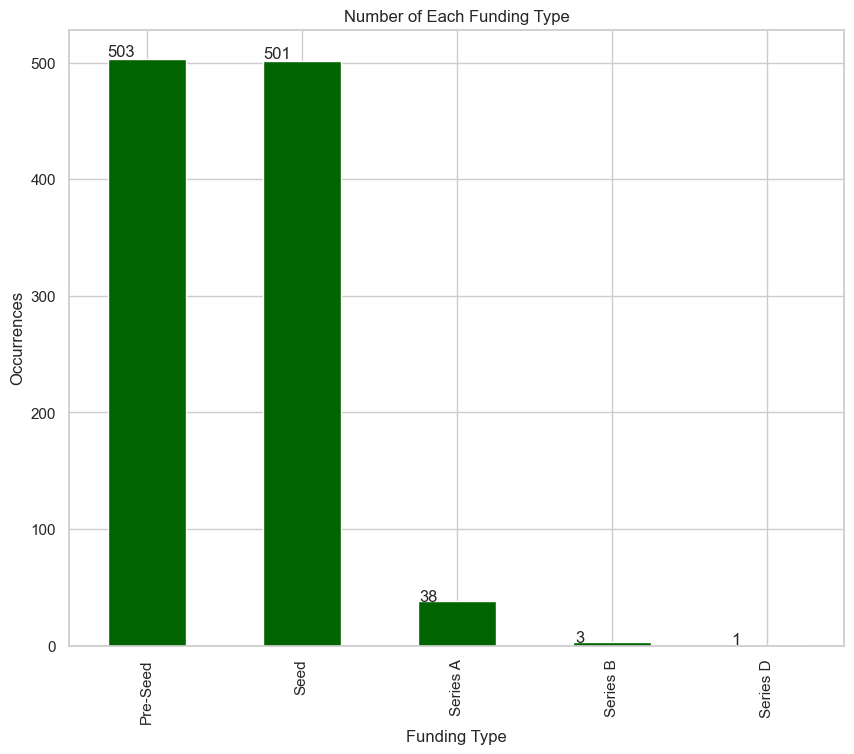

Number of each funding type: 


Last Funding Type
Pre-Seed    503
Seed        501
Series A     38
Series B      3
Series D      1
Name: count, dtype: int64

In [92]:
# Counting the occurrences of each funding type
funding_type_counts = df['Last Funding Type'].value_counts()

# Creating a bar plot
plt.figure(figsize=(10, 8))
ax = funding_type_counts.plot(kind='bar', color='darkgreen')

# Adding the number of companies on top of the barscount_df
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=12)

# Setting title and labels with Times New Roman font
plt.title('Number of Each Funding Type')
plt.xlabel('Funding Type')
plt.ylabel('Occurrences')
plt.xticks()
plt.show()

print('Number of each funding type: ')
display(funding_type_counts)

In [93]:
# Applying an ordinal scale to 'Last Funding Type'
scale_mapper = {
'Pre-Seed': 1,
'Seed': 2,
'Series A': 3,
'Series B': 4, 
'Series C': 5,
'Series D': 6,  
'Series E': 7     
    }

df['Last Funding Type ORD'] = df['Last Funding Type'].replace(scale_mapper)

/var/folders/xt/0h_f_zjs1hvcdg6rdl1hs5_c0000gn/T/ipykernel_89900/952003956.py:12: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7964 entries, 2 to 17978
Data columns (total 52 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   ID                                      7964 non-null   int64         
 1   company                                 7964 non-null   object        
 2   Founded Date                            7964 non-null   datetime64[ns]
 3   website                                 7964 non-null   object        
 4   Headquarters Location                   7964 non-null   object        
 5   Industry Groups                         7964 non-null   object        
 6   Industries                              7964 non-null   object        
 7   CB Rank (Company)                       7964 non-null   float64       
 8   Full Description                        4794 non-null   object        
 9   Number of Employees                     7964 non-null   

In [95]:
# Adding binary variable for reaching Series A (1 = series A reached)
df['Series_A_bin'] = np.where(df['Last Funding Type ORD'] > 2, 1, 0)
df['Series_A_bin'] = df['Series_A_bin'].astype(bool)

### Number of Employees

In [96]:
df['Number of Employees'].unique()

array(['1-10', '51-100', '11-50', '101-250', '251-500', '10001+',
       '501-1000', '1001-5000', '5001-10000'], dtype=object)

In [97]:
# Defining the mapping
ordinal_map = {
    '1-10': 1,
    '11-50': 2,
    '51-100': 3,
    '101-250': 4,
    '251-500': 5,
    '501-1000': 6,
    '1001-5000': 7,
    '5001 - 10000': 9,
    '10001+': 8
}

# Applying the mapping
df['Number of Employees ORD'] = df['Number of Employees'].map(ordinal_map)

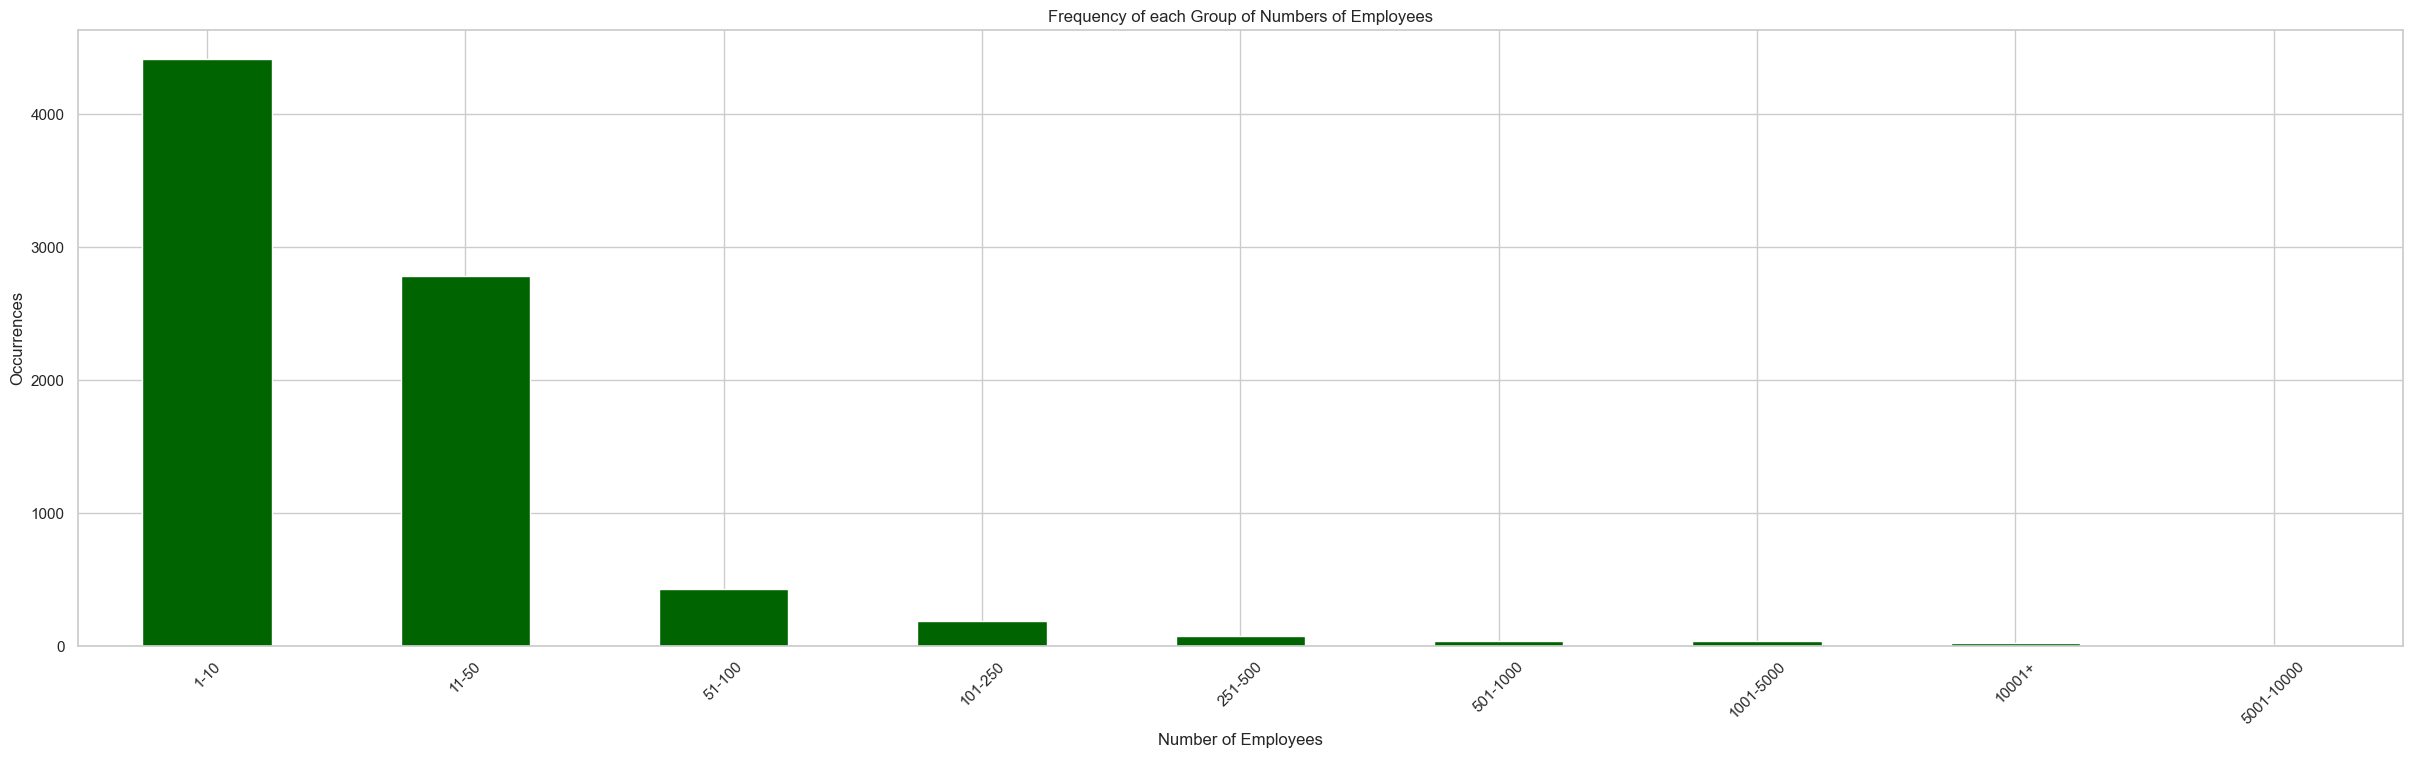

In [98]:
# Counting all values of column 'Number of Employees'
employee_counts = df['Number of Employees'].value_counts()

# Creating a bar plot
plt.figure(figsize=(30, 8))
employee_counts.plot(kind='bar', color = 'darkgreen')
plt.title('Frequency of each Group of Numbers of Employees')
plt.xlabel('Number of Employees')
plt.ylabel('Occurrences')
plt.xticks(rotation=45)
plt.show()

# Data Cleaning

In [99]:
df.head()

,ID,company,Founded Date,website,Headquarters Location,Industry Groups,Industries,CB Rank (Company),Full Description,Number of Employees,...,AI_bin,Founded Year,Year_2018,Year_2019,Year_2020,Year_2021,Year_2022,Last Funding Type ORD,Series_A_bin,Number of Employees ORD
2,17422,PromptLayer,2021-08-01,https://www.promptlayer.com,"New York, New York, United States",Software,Software,130969.0,NaN,1-10,...,False,2021,False,False,False,True,False,1.0,False,1.0
3,82006,American Safety,2019-01-01,https://american-safetyllc.com,"Belle Chasse, Louisiana, United States","Commerce and Shopping, Education, Manufacturing","Industrial, Rental, Training",2051287.0,NaN,51-100,...,False,2019,False,True,False,False,False,NaN,False,3.0
4,58824,Nerdee's,2020-01-01,https://www.nerdees.com,"Walnut, California, United States","Clothing and Apparel, Commerce and Shopping, C...","Apparel, E-Commerce, Fashion, Shoes",1038376.0,"Nerdee's a seller of clothing, accessories, ga...",11-50,...,False,2020,False,False,True,False,False,NaN,False,2.0
6,58333,Ziegel,2018-07-06,https://www.ziegel.es,"Playa Del Rey, California, United States",Real Estate,Real Estate,987441.0,"We offer support, infrastructures and conditio...",51-100,...,False,2018,True,False,False,False,False,NaN,False,3.0
10,25169,Lodestar,2019-08-01,https://www.lodestar.ai,"San Jose, California, United States","Artificial Intelligence (AI), Data and Analyti...","Artificial Intelligence (AI), Computer Vision,...",216067.0,With Lodestar you can annotate video far faste...,11-50,...,True,2019,False,True,False,False,False,NaN,False,2.0


In [100]:
# Filling NAs for columns where data is not misisng at random
df['Total Funding Amount Currency (in USD)'] = df['Total Funding Amount Currency (in USD)'].fillna(0)
df['ai_keyword_count'] = df['ai_keyword_count'].fillna(0)
df['matched_keywords'] = df['matched_keywords'].fillna(0)
df['Last Funding Type ORD'] = df['Last Funding Type ORD'].fillna(0)

In [101]:
# Creating copies of the final full dataframe to use later for other purposes where all features could be relevant
descriptive_df = df.copy()
scraped_df = df.copy()

In [102]:
# Removing Features irrelevant to the analysis 
columns_to_drop = [
    "ID", "company", "website", "Headquarters Location", "Industries",
    "CB Rank (Company)", "Full Description", "Funding Status", "Last Funding Date", "Last Funding Type",
    "Number of Founders","Number of Employees", "Number of Employees.1", "IPO Status", "IPO Date", "Valuation at IPO Currency (in USD)",
    "IPqwery - Patents Granted", "IPqwery - Trademarks Registered", "IPqwery - Most Popular Patent Class",
    "org_uuid", "Unnamed: 0", "source_y", "text", "type",
    #"closest_snapshot", 
    "closest_snapshot_time",
    "snapshot_in_window",'text_preprocessed',  "Founded Year", 
    "NA Count", 
    #'timestamp'
]

df = df.drop(columns=columns_to_drop)

# Checking the final dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7964 entries, 2 to 17978
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Founded Date                            7964 non-null   datetime64[ns]
 1   Industry Groups                         7964 non-null   object        
 2   Number of Funding Rounds                7964 non-null   float64       
 3   Last Funding Amount Currency (in USD)   7964 non-null   float64       
 4   Total Funding Amount Currency (in USD)  7964 non-null   float64       
 5   age                                     7964 non-null   int64         
 6   founding_year                           7964 non-null   int64         
 7   source_x                                7964 non-null   int64         
 8   text_len                                7964 non-null   float64       
 9   closest_snapshot                        6245 non-null   

In [103]:
df.head()

,Founded Date,Industry Groups,Number of Funding Rounds,Last Funding Amount Currency (in USD),Total Funding Amount Currency (in USD),age,founding_year,source_x,text_len,closest_snapshot,...,fund_success,AI_bin,Year_2018,Year_2019,Year_2020,Year_2021,Year_2022,Last Funding Type ORD,Series_A_bin,Number of Employees ORD
2,2021-08-01,Software,1.0,0.0,0.0,2,2021,0,103.0,"{'status': '200', 'available': True, 'url': 'h...",...,False,False,False,False,False,True,False,1.0,False,1.0
3,2019-01-01,"Commerce and Shopping, Education, Manufacturing",0.0,0.0,0.0,5,2019,0,7306.0,"{'status': '200', 'available': True, 'url': 'h...",...,False,False,False,True,False,False,False,0.0,False,3.0
4,2020-01-01,"Clothing and Apparel, Commerce and Shopping, C...",0.0,0.0,0.0,4,2020,0,195537.0,"{'status': '200', 'available': True, 'url': 'h...",...,False,False,False,False,True,False,False,0.0,False,2.0
6,2018-07-06,Real Estate,0.0,0.0,0.0,5,2018,0,1684.0,"{'status': '200', 'available': True, 'url': 'h...",...,False,False,True,False,False,False,False,0.0,False,3.0
10,2019-08-01,"Artificial Intelligence (AI), Data and Analyti...",0.0,0.0,0.0,4,2019,0,207.0,NaN,...,False,True,False,True,False,False,False,0.0,False,2.0


# Descriptive Statistics
For the descriptive statistics I'm using a copy of the main dataframe 'df' that still contains all columns to be more versatile in my analyses.

In [104]:
descriptive_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7964 entries, 2 to 17978
Data columns (total 54 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   ID                                      7964 non-null   int64         
 1   company                                 7964 non-null   object        
 2   Founded Date                            7964 non-null   datetime64[ns]
 3   website                                 7964 non-null   object        
 4   Headquarters Location                   7964 non-null   object        
 5   Industry Groups                         7964 non-null   object        
 6   Industries                              7964 non-null   object        
 7   CB Rank (Company)                       7964 non-null   float64       
 8   Full Description                        4794 non-null   object        
 9   Number of Employees                     7964 non-null   

## General Stats

In [105]:
# Creating first summaries of the numerical features
descriptive_stats = df.describe(include=[np.number]) # Only numerical columns
display(descriptive_stats)

,Number of Funding Rounds,Last Funding Amount Currency (in USD),Total Funding Amount Currency (in USD),age,founding_year,source_x,text_len,ai_keyword_count,Last Funding Type ORD,Number of Employees ORD
count,7964.000000,7.964000e+03,7.964000e+03,7964.000000,7964.000000,7964.000000,7964.000000,7964.000000,7964.000000,7960.000000
mean,0.131341,1.518185e+05,1.518185e+05,3.746861,2020.035158,0.105098,14604.133601,0.770593,0.205550,1.626508
std,0.337794,2.041098e+06,2.041098e+06,1.108328,1.070077,0.306699,20429.384281,3.512127,0.571028,0.951164
min,0.000000,0.000000e+00,0.000000e+00,1.000000,2018.000000,0.000000,50.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000e+00,0.000000e+00,3.000000,2019.000000,0.000000,2972.750000,0.000000,0.000000,1.000000
50%,0.000000,0.000000e+00,0.000000e+00,4.000000,2020.000000,0.000000,8942.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000e+00,0.000000e+00,5.000000,2021.000000,0.000000,19096.500000,0.000000,0.000000,2.000000
max,1.000000,9.500000e+07,9.500000e+07,5.000000,2022.000000,1.000000,493990.000000,71.000000,6.000000,8.000000


In [106]:
# Creating first summaries of non-numerical features
descriptive_stats_categorical = descriptive_df.describe(include=[object])  # Only object columns
display(descriptive_stats_categorical)

,company,website,Headquarters Location,Industry Groups,Industries,Full Description,Number of Employees,Funding Status,Last Funding Type,Number of Employees.1,...,IPqwery - Patents Granted,IPqwery - Trademarks Registered,IPqwery - Most Popular Patent Class,source_y,text,type,closest_snapshot,text_preprocessed,matched_keywords,Headquarters State
count,7964,7964,7964,7964,7964,4794,7964,1170,1046,7964,...,661,661,94,7964,7964,7964,6245,7956,7964,7964
unique,7948,7964,1699,2951,6314,4794,9,5,5,9,...,28,29,26,1,7877,1,6244,7876,142,51
top,Croft,https://www.promptlayer.com,"New York, New York, United States",Health Care,Software,"Nerdee's a seller of clothing, accessories, ga...",1-10,Seed,Pre-Seed,1-10,...,0.0,1.0,Computing; Calculating,crunchbase,"One moment, Please wait while your request is...",startup,"{'status': '200', 'available': True, 'url': 'h...",one moment please wait request,0,California
freq,2,1,706,353,86,1,4410,974,503,4410,...,501,236,23,7964,24,7964,2,24,6876,1815


In [107]:
# Calculating the number of startups that received funding
print(f"Number of all Startups with funding: {len(descriptive_df[descriptive_df['funding_bin']== 1])}")

Number of all Startups with funding: 546


## Funding Distribution - pre-clean

## Age Distribution

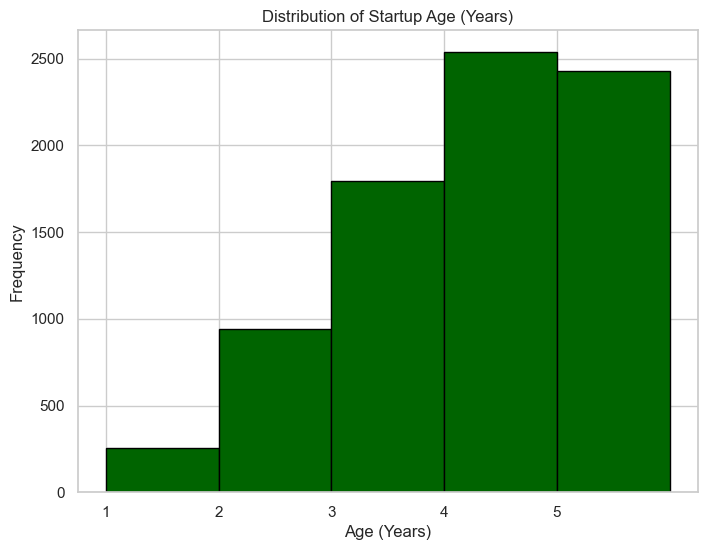

In [108]:
# Filtering non-null 'text_preprocessed' values
df_Figure = descriptive_df[descriptive_df['text_preprocessed'].notna()]

# Setting Seaborn style
sns.set(style="whitegrid")

# Creating the histogram for Company Ages
plt.figure(figsize=(8, 6))

# Setting the bins to align with integer ages
bins = [1, 2, 3, 4, 5, 6]

sns.histplot(df_Figure['age'], bins=bins, kde=False, color='darkgreen', edgecolor='black', alpha=1)
plt.xticks(bins[:-1])  # Adjust x-ticks to match the integer bins
plt.title('Distribution of Startup Age (Years)')
plt.xlabel('Age (Years)')
plt.ylabel('Frequency')

# Displaying and saving the plot
plt.savefig('Plots/Descriptive Statistics/Age Distribution', dpi = 300, bbox_inches = 'tight')
plt.show()

In [109]:
# Printing Distribution Statistics for age
age_distribution = descriptive_df['age'].describe()
print("Age Distribution:\n", age_distribution)
print(f"Median Age: {descriptive_df['age'].median()}")

Age Distribution:
 count    7964.000000
mean        3.746861
std         1.108328
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: age, dtype: float64
Median Age: 4.0


## Geographic Distribution

In [110]:
# Preparing the data
state_counts = scraped_df['Headquarters State'].value_counts().reset_index()
state_counts.columns = ['State', 'Count']

# Mapping state names acronyms
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Converting full state names to acronyms
state_counts['State_short'] = state_counts['State'].map(state_abbreviations)

# Setting custom color scale
custom_scale = [
    (0.0, "gainsboro"),
    (1.0, "darkgreen")
]

# Creating the choropleth map
fig = px.choropleth(
    state_counts,
    locations='State_short',
    locationmode='USA-states',
    color='Count',
    color_continuous_scale=custom_scale,  # Implementing custom color scale
    scope="usa",
    title='Distribution of Companies Across the US States'
)

# Adding fonts and a scale
fig.update_layout(
    title={'text': 'Distribution of Companies Across the US States', 'font': {'family': 'Times New Roman'}},
    font=dict(family="Times New Roman"),
    coloraxis_colorbar=dict(
        title={'text': 'Company Count', 'font': {'family': 'Times New Roman'}},
        tickvals=[state_counts['Count'].min(), state_counts['Count'].max()],
        ticktext=['Low', 'High']
    ),
    width=1000,
    height=600
)

# Displaying and saving the figure
fig.write_image('Plots/Descriptive Statistics/State Map.png', scale=4)
fig.show()


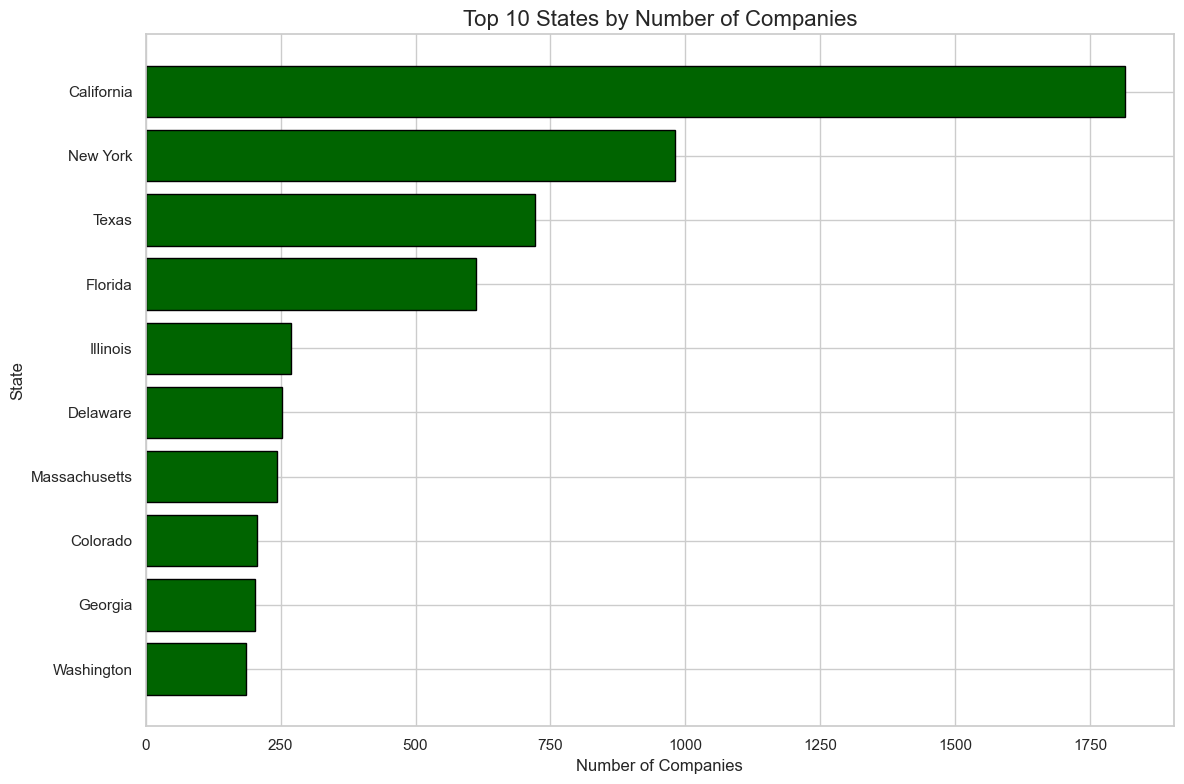

In [111]:
# Sorting the DataFrame by 'Count' in descending order and selecting the top 10
top_states = state_counts.sort_values(by='Count', ascending=False).head(10)

# Creating a horizontal bar plot
plt.figure(figsize=(12, 8))  # Set the figure size larger for full state names
plt.barh(top_states['State'], top_states['Count'], color='darkgreen', edgecolor='black')  # Create a horizontal bar chart
plt.gca().invert_yaxis()

# Adding labels and title
plt.xlabel('Number of Companies', fontsize=12)
plt.ylabel('State', fontsize=12)  
plt.title('Top 10 States by Number of Companies', fontsize=16)  

# Displaying the plot
plt.tight_layout() 
plt.show()  

In [112]:
print("Number of Companies in the top states")
display(state_counts.head(10))

Number of Companies in the top states


,State,Count,State_short
0,California,1815,CA
1,New York,980,NY
2,Texas,722,TX
3,Florida,613,FL
4,Illinois,270,IL
5,Delaware,252,DE
6,Massachusetts,243,MA
7,Colorado,206,CO
8,Georgia,202,GA
9,Washington,185,WA


In [113]:
# Calculating the total number of companies per state
total_counts = scraped_df['Headquarters State'].value_counts().reset_index()
total_counts.columns = ['State', 'Total_Count']

# Calculating the number of companies per state where keyword_bin is True
filtered_df = scraped_df[scraped_df['keyword_bin'] == True]
keyword_counts = filtered_df['Headquarters State'].value_counts().reset_index()
keyword_counts.columns = ['State', 'Keyword_Count']

# Merging the two dataframes on the state column
state_counts = total_counts.merge(keyword_counts, on='State', how='left')
state_counts['Keyword_Count'] = state_counts['Keyword_Count'].fillna(0)

# Calculating the percentage of companies with keyword_bin = True
state_counts['Percentage'] = (state_counts['Keyword_Count'] / state_counts['Total_Count']) * 100

# Converting  full state names to abbreviations in your DataFrame
state_counts['State_short'] = state_counts['State'].map(state_abbreviations)

custom_scale = [
    (0.0, "gainsboro"),       # start with gainsboro at 0%
    (1.0, "darkgreen")        # dark green at 100%
]

# Creating the choropleth map
fig = px.choropleth(
    state_counts,
    locations='State_short',
    locationmode='USA-states',
    color='Percentage',
    color_continuous_scale=custom_scale,  # Use custom color scale
    scope="usa",
    title='Percentage of Companies with Keyword Across the US States'
)

# Adding a color scale
fig.update_layout(
    coloraxis_colorbar=dict(
        title='Percentage (%)',
        tickvals=[state_counts['Percentage'].min(), state_counts['Percentage'].median(), state_counts['Percentage'].max()],
        ticktext=['Low', 'Medium', 'High']
    ), 
    width=1000,
    height=600
)

# Showing the figure
fig.show()


In [114]:
print("Number of Companies in the top states")
display(state_counts.head(10))

Number of Companies in the top states


,State,Total_Count,Keyword_Count,Percentage,State_short
0,California,1815,347.0,19.118457,CA
1,New York,980,125.0,12.755102,NY
2,Texas,722,83.0,11.495845,TX
3,Florida,613,53.0,8.646003,FL
4,Illinois,270,37.0,13.703704,IL
5,Delaware,252,52.0,20.634921,DE
6,Massachusetts,243,58.0,23.868313,MA
7,Colorado,206,22.0,10.679612,CO
8,Georgia,202,26.0,12.871287,GA
9,Washington,185,27.0,14.594595,WA


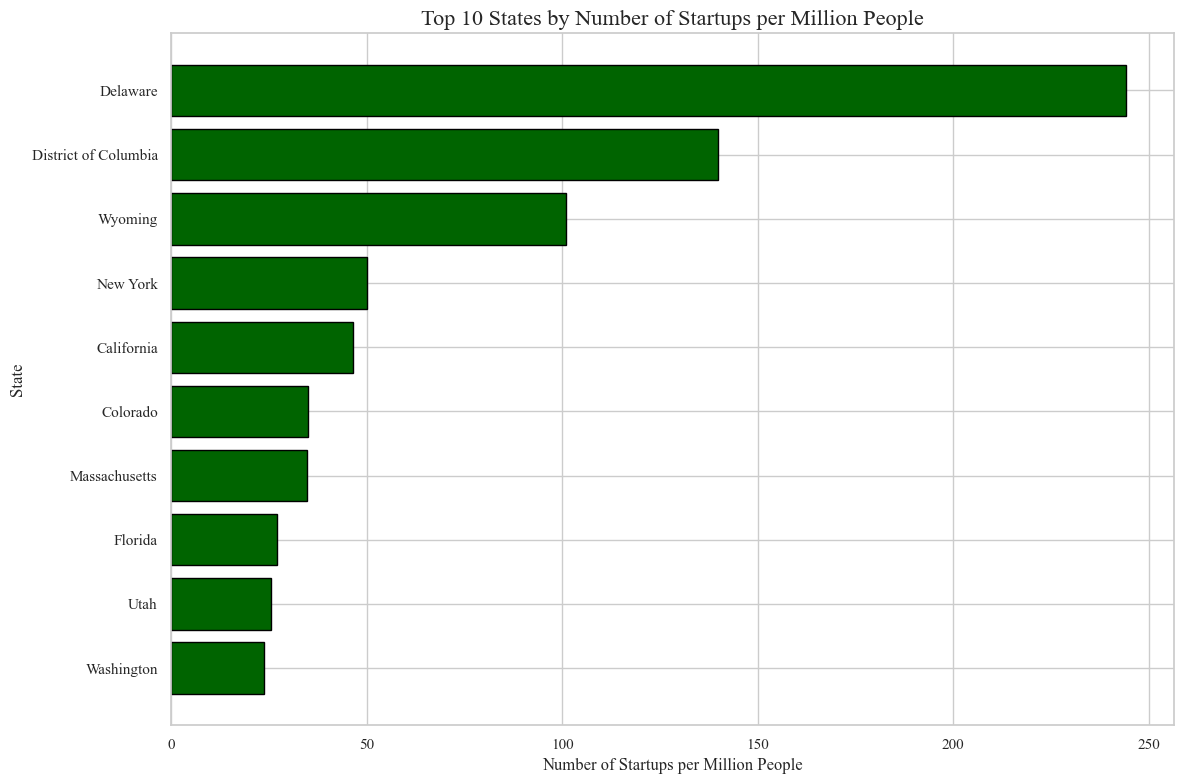

In [116]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculating the total number per state
state_counts = descriptive_df['Headquarters State'].value_counts().reset_index()
state_counts.columns = ['State', 'Count']

# Loading the population data from the Excel file
population_df = pd.read_excel('Data/External Figure Data/Population by state.xlsx')

# Merging the population data with the state_counts DataFrame
merged_df = state_counts.merge(population_df, left_on='State', right_on='NAME', how='left')

# Calculating companies per capita (multiplying by a factor of 1 million for better readability)
merged_df['Companies per Million People'] = (merged_df['Count'] / merged_df['POPESTIMATE2023']) * 1e6

# Sorting by the new metric and selecting the top 10 states
top_states_per_capita = merged_df.sort_values('Companies per Million People', ascending=False).head(10)

# Set the font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

# Creating a horizontal bar plot
plt.figure(figsize=(12, 8))
plt.barh(top_states_per_capita['State'], top_states_per_capita['Companies per Million People'], color='darkgreen', edgecolor='black')
plt.gca().invert_yaxis()
plt.xlabel('Number of Startups per Million People', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.title('Top 10 States by Number of Startups per Million People', fontsize=16)

# Displaying the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.savefig('Plots/Descriptive Statistics/Startups per Mil.png', dpi=300, bbox_inches='tight')
plt.show()


## Characteristics of Scraping

In [77]:
descriptive_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7964 entries, 2 to 17978
Data columns (total 54 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   ID                                      7964 non-null   int64         
 1   company                                 7964 non-null   object        
 2   Founded Date                            7964 non-null   datetime64[ns]
 3   website                                 7964 non-null   object        
 4   Headquarters Location                   7964 non-null   object        
 5   Industry Groups                         7964 non-null   object        
 6   Industries                              7964 non-null   object        
 7   CB Rank (Company)                       7964 non-null   float64       
 8   Full Description                        4794 non-null   object        
 9   Number of Employees                     7964 non-null   

In [78]:
# Filter rows where 'text_preprocessed' is not null
filtered_df = descriptive_df[descriptive_df['text_preprocessed'].notnull()]

# Basic descriptive statistics for the filtered data
descriptive_stats_filtered = filtered_df.describe(include='all')
print("Descriptive Statistics for Companies with Text Data:")
print(descriptive_stats_filtered)

# Calculate average text length
average_text_length = filtered_df['text_len'].mean()
print("\nAverage Text Length:", average_text_length)

# Convert 'founding_year' to datetime (assuming it's a full year)
filtered_df['founding_year'] = pd.to_datetime(filtered_df['founding_year'], format='%Y', errors='coerce')

# Convert 'Last Funding Date' to datetime
filtered_df['Last Funding Date'] = pd.to_datetime(filtered_df['Last Funding Date'], errors='coerce')

# Calculate the average distance in days between 'founding_year' and 'Last Funding Date'
filtered_df['date_difference'] = (filtered_df['Last Funding Date'] - filtered_df['founding_year']).dt.days
average_date_difference = filtered_df['date_difference'].mean()
average_date_difference_years = (average_date_difference) / 365.25
print("\nAverage Days between Founding Year and Last Funding Date:", average_date_difference, 'or ', average_date_difference_years, ' years.' )

median_date_difference = filtered_df['date_difference'].median()
median_date_difference_years = (median_date_difference)/ 365.25
print("\nMedian Days between Founding Year and Last Funding Date:", median_date_difference, 'or ', median_date_difference_years, ' years.' )


Descriptive Statistics for Companies with Text Data:
                   ID company                   Founded Date  \
count     7956.000000    7956                           7956   
unique            NaN    7940                            NaN   
top               NaN  Fitted                            NaN   
freq              NaN       2                            NaN   
mean     56650.907994     NaN  2020-03-01 15:04:26.063348480   
min         60.000000     NaN            2018-03-19 00:00:00   
25%      35179.000000     NaN            2019-01-01 00:00:00   
50%      55412.000000     NaN            2020-01-01 00:00:00   
75%      77858.000000     NaN            2021-01-01 00:00:00   
max     104945.000000     NaN            2022-12-31 00:00:00   
std      25968.007204     NaN                            NaN   

                            website              Headquarters Location  \
count                          7956                               7956   
unique                        

/var/folders/xt/0h_f_zjs1hvcdg6rdl1hs5_c0000gn/T/ipykernel_89900/1619899855.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xt/0h_f_zjs1hvcdg6rdl1hs5_c0000gn/T/ipykernel_89900/1619899855.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/xt/0h_f_zjs1hvcdg6rdl1hs5_c0000gn/T/ipykernel_89900/1619899855.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

## Characteristics of Companies using AI

### Total Funding per Investment Series

In [79]:
# Mapping the 'Last Funding Type' column to a numerical scale
descriptive_df['Funding Series'] = descriptive_df['Last Funding Type'].map(scale_mapper)

# Defining function to calculate average funding scaled to millions of USD
def calculate_average_funding(dataframe, condition=None):
    if condition is not None:
        dataframe = dataframe[dataframe[condition]]
    # Divide by 10^6 to convert to millions
    return dataframe.groupby('Funding Series')['Total Funding Amount Currency (in USD)'].mean() / 1e6

# Defining funciton to calculate total funding scaled to millions of USD
def calculate_total_funding(dataframe, condition=None):
    if condition is not None:
        dataframe = dataframe[dataframe[condition]]
    # Divide by 10^6 to convert to millions
    return dataframe['Total Funding Amount Currency (in USD)'].sum() / 1e6

# Calculating average funding for each series overall
average_funding_overall = calculate_average_funding(descriptive_df)

# Calculating average funding for each series where keyword_bin is True
average_funding_keyword = calculate_average_funding(descriptive_df, condition='keyword_bin')

# Calculating average funding for each series where AI_bin is True
average_funding_ai = calculate_average_funding(descriptive_df, condition='AI_bin')

# Calculating total funding for the whole DataFrame and for conditions
total_funding_overall = calculate_total_funding(descriptive_df)
total_funding_keyword = calculate_total_funding(descriptive_df, condition='keyword_bin')
total_funding_ai = calculate_total_funding(descriptive_df, condition='AI_bin')

# Creating a DataFrame with the results
funding_table = pd.DataFrame({
    'Average Total Funding (All) (Million USD)': average_funding_overall,
    'Average Total Funding (Keyword True) (Million USD)': average_funding_keyword,
    'Average Total Funding (AI True) (Million USD)': average_funding_ai
})

# Appending a row with the total funding
funding_table.loc['Total'] = [total_funding_overall, total_funding_keyword, total_funding_ai]

# Mappping the index back to the series name for clarity, except for the 'Total' row
index_mapper = {v: k for k, v in scale_mapper.items()}
index_mapper['Total'] = 'Total'
funding_table.index = funding_table.index.map(index_mapper)

display(funding_table)


,Average Total Funding (All) (Million USD),Average Total Funding (Keyword True) (Million USD),Average Total Funding (AI True) (Million USD)
Funding Series,,,
Pre-Seed,0.247466,0.228641,0.233732
Seed,1.158925,1.495731,0.937061
Series A,12.436473,5.937500,10.021429
Series B,10.466667,NaN,NaN
Series D,0.000000,0.000000,NaN
Total,1209.082632,175.932850,211.798844


# Exporting all relevant Datframes

In [80]:
df.to_csv('Data/Working Dataframes/df.csv')
scraped_df.to_csv('Data/Working Dataframes/scraped_df.csv')
descriptive_df.to_csv('Data/Working Dataframes/descriptive_df.csv')